In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0513

/content/drive/MyDrive/Colab Notebooks/기계시스템설계/23년/baseline0513


In [4]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


SystemError: ignored

In [3]:
!pip install fmpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 15.7 MB/s eta 0:00:00


In [4]:
from fmpy import read_model_description, extract
from fmpy.fmi2 import FMU2Slave
from fmpy.util import plot_result, download_test_file
import numpy as np
import pandas as pd
import shutil
import matplotlib.pyplot as plt

import random
import numpy as np
import torch
import argparse
import os
import sys
import numpy as np
import tensorflow as tf
from tensorflow import keras
from collections import deque
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras import layers
import scipy.signal
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch import FloatTensor as FT
import tensorflow_probability as tfp

In [5]:
fmu_filename = 'HEV_TMED_Simulator_Rearrange_230511_linux.fmu'
start_time = 0.0
stop_time = 1800.0
step_size = 0.01
soc_init = 67

# WLTP profile에 대하여 시험
with open("wltp_vehicle_speed_profile_real.csv") as file_name:
    vehicle_speed_profile = np.loadtxt(file_name, delimiter=",")

In [6]:
class HEV:
    def __init__(self, fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile):
        self.fmu_filename = fmu_filename
        self.vrs = {}
        self.start_time = start_time
        self.stop_time = stop_time
        self.step_size = step_size
        self.time = self.start_time
        self.vehicle_speed_profile = vehicle_speed_profile
        self.soc_init = soc_init/5000
        self.state_init = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.state = np.array([self.soc_init, 0, 0, 0, 0, 0, 0, 0, 0]).reshape(1,-1)
        self.action_upper_bound = 15000
        self.action_lower_bound = -15000
        #self.action_space = [[13500, 2000], [500, 2000], [13500, -15000], [500, -15000]]
        self.obssize = len(self.state[0])
        self.actsize = 2
        
    def step(self, action):
        #a = self.action_space[action]
#         action = action*self.action_upper_bound
        a1 = action[0]*self.action_upper_bound
        a2 = action[0]*self.action_upper_bound
        a3 = self.soc_init
        a4 = action[1]/2 + 1
        instant_veh_speed = np.interp(self.time, self.vehicle_speed_profile[:,0], self.vehicle_speed_profile[:,1])
        self.fmu.setReal([self.vr_input1, self.vr_input2, self.vr_input3, self.vr_input4, self.vr_input5], [instant_veh_speed, a1, a2, a3, a4]) #input variable, input key(13500 2000)
        self.fmu.doStep(currentCommunicationPoint=self.time, communicationStepSize=self.step_size)
#         [output1, output2, output3, output4, output5, output6, output7] = self.fmu.getReal([self.vr_output1,self.vr_output2, self.vr_output3, self.vr_output4, self.vr_output5, self.vr_output6, self.vr_output7])
#         self.state = [output1, output2, output3, output4, output5, output6, output7]
        state = np.array(self.fmu.getReal(np.arange(35)))/5000
        state_column = np.array([self.vrs['Bat_SOC'], self.vrs['nEngOn'], self.vrs['PT_tqTmInDmd_Nm_P2'], self.vrs['ObEng_nEng_Rpm'], self.vrs['TrEtp_tqEngMAF_Nm'], self.vrs['TrP0_tqP0_Nm'], self.vrs['TrP2_tqP2_Nm'], self.vrs['Driver_sVeh_kph'], self.vrs['BSFC_g_kWh[1]']])
        self.state = state[state_column]
        soc = state[self.vrs['Bat_SOC']]
        BSFC = state[self.vrs['BSFC_g_kWh[1]']]
        reward = - 5000*(self.soc_init - soc) ** 2 - 10*BSFC
        is_done = lambda time: time >= self.stop_time
        self.time += self.step_size
        return self.state.reshape(1,-1), reward, is_done(self.time), None
    
    def reset(self):
        self.state = self.state_init
        model_description = read_model_description(self.fmu_filename)
        for variable in model_description.modelVariables:
            self.vrs[variable.name] = variable.valueReference
        unzipdir = extract(fmu_filename)
        self.fmu = FMU2Slave(guid=model_description.guid,
                       unzipDirectory=unzipdir,
                       modelIdentifier=model_description.coSimulation.modelIdentifier,
                       instanceName='instance1')
        self.fmu.instantiate()
        self.fmu.setupExperiment(startTime=self.start_time)
        self.fmu.enterInitializationMode()
        self.fmu.exitInitializationMode()
        self.time = self.start_time
        
        self.vr_input1 = self.vrs['Driver_sVeh_Target_kph']
        self.vr_input2 = self.vrs['Engine_on_line']
        self.vr_input3 = self.vrs['Engine_off_line']
        self.vr_input4 = self.vrs['soc_init']
        self.vr_input5 = self.vrs['Engine_OOL']
        self.vr_output1 = self.vrs['TgMod_fPt']
        self.vr_output2 = self.vrs['P2_wElec_W']
        self.vr_output3 = self.vrs['P4_wElec_W']
        self.vr_output4 = self.vrs['ObP2_wElecBIntv_W']
        self.vr_output5 = self.vrs['EV_on_line']
        self.vr_output6 = self.vrs['EV_off_line']
        self.vr_output7 = self.vrs['Bat_SOC']
        self.vr_output8 = self.vrs['PT_tqTmInDmd_Nm_P2']
        self.vr_output9 = self.vrs['P0_wElec_W']
        self.vr_output10 = self.vrs['Pwr_Aux_W']
        self.vr_output11 = self.vrs['ObEng_nEng_Rpm']
        self.vr_output12 = self.vrs['TrEtp_tqEngMAF_Nm']
        self.vr_output13 = self.vrs['rpm_P0']
        self.vr_output14 = self.vrs['TM_F_nTmIn_rpm']
        self.vr_output15 = self.vrs['TM_R_nTmIn_rpm']
        self.vr_output16 = self.vrs['eBat_kWh']
        self.vr_output17 = self.vrs['nEngOn']
        self.vr_output18 = self.vrs['TrP0_tqP0_Nm']
        self.vr_output19 = self.vrs['TrP2_tqP2_Nm']
        self.vr_output20 = self.vrs['TrP4_tqP4_Nm']
        self.vr_output21 = self.vrs['TCU_F_fCurGe']
        self.vr_output22 = self.vrs['TCU_F_fTarGe']
        self.vr_output23 = self.vrs['Driver_sVeh_kph']
        self.vr_output24 = self.vrs['Eng_eff_avg']
        self.vr_output25 = self.vrs['TM_F_P0P2_eff_avg']
        self.vr_output26 = self.vrs['TM_F_P0P4_eff_avg']
        self.vr_output27 = self.vrs['BSFC_g_kWh[1]']
        self.vr_output28 = self.vrs['BSFC_g_kWh[2]']
        self.vr_output29 = self.vrs['BSFC_g_kWh[3]']
        
        return self.state.reshape(1,-1)

In [33]:
action_grid = []
for i in np.linspace(-1.0, 1.0, 11):
  for j in np.linspace(-1.0, 1.0, 11):
    action_grid.append((i,j))
action_grid

[(-1.0, -1.0),
 (-1.0, -0.8),
 (-1.0, -0.6),
 (-1.0, -0.3999999999999999),
 (-1.0, -0.19999999999999996),
 (-1.0, 0.0),
 (-1.0, 0.20000000000000018),
 (-1.0, 0.40000000000000013),
 (-1.0, 0.6000000000000001),
 (-1.0, 0.8),
 (-1.0, 1.0),
 (-0.8, -1.0),
 (-0.8, -0.8),
 (-0.8, -0.6),
 (-0.8, -0.3999999999999999),
 (-0.8, -0.19999999999999996),
 (-0.8, 0.0),
 (-0.8, 0.20000000000000018),
 (-0.8, 0.40000000000000013),
 (-0.8, 0.6000000000000001),
 (-0.8, 0.8),
 (-0.8, 1.0),
 (-0.6, -1.0),
 (-0.6, -0.8),
 (-0.6, -0.6),
 (-0.6, -0.3999999999999999),
 (-0.6, -0.19999999999999996),
 (-0.6, 0.0),
 (-0.6, 0.20000000000000018),
 (-0.6, 0.40000000000000013),
 (-0.6, 0.6000000000000001),
 (-0.6, 0.8),
 (-0.6, 1.0),
 (-0.3999999999999999, -1.0),
 (-0.3999999999999999, -0.8),
 (-0.3999999999999999, -0.6),
 (-0.3999999999999999, -0.3999999999999999),
 (-0.3999999999999999, -0.19999999999999996),
 (-0.3999999999999999, 0.0),
 (-0.3999999999999999, 0.20000000000000018),
 (-0.3999999999999999, 0.400000000

In [8]:
def generate_actionlist(timestep, act):
  action_buffer = {}  
  action_array = np.zeros([timestep, len(act)])

  for i in range(timestep):
    action_buffer[i] = list(range(len(act)))
  for j in range(len(act)):
    for i in range(timestep): 
      idx = np.random.randint(0,len(act)-j)
      idx = action_buffer[i][idx]
      action_array[i][j] = idx
      action_buffer[i].remove(idx)
  return action_array
    # print('{0}, {1}'.format(i, j))
# print(action_buffer)

In [9]:
def policy_evaluation(value_array,timestep, action_grid, iter_num, dis=1.0):
  # if iter_num == 0:
  #   print('Iteration: {} \n{}\n'.format(iter_num, post_value_table))
  #   return post_value_table

  # value_array = np.zeros([timestep, len(action_grid)], dtype = float)


  for iteration in range(iter_num):
    # next_value_table = np.zeros([timestep, 1], dtype=float)
    for i in range(len(action_grid)):
      env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
      env.reset()
      for j in range(timestep):
        action_idx = int(action_array[j,i])
        s,r,done,_ = env.step(action_grid[action_idx])
        value_array[j,action_idx] = r + dis*value_array[j,action_idx]
    # iteration += 1
      print('{} complete'.format(i))

    # print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    # print('---------------------------------------------------------------------------------------------------------')
    
    # if (iteration % 10) != iter_num: 
    #         # print result 
    #         if iteration > 100 :
    #             if (iteration % 20) == 0: 
    #                 print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    #         else :
    #             if (iteration % 10) == 0:
    #                 print('Iteration: {} \n{}\n'.format(iteration, next_value_table))
    # else :
    #   print('Iteration: {} \n{}\n'.format(iteration, next_value_table ))
    
    post_value_table = value_array

  return value_array


In [16]:
action_array = generate_actionlist(180000,action_grid)
action_array.shape

(180000, 121)

In [17]:
start = time.time()
# table = np.zeros([180000, len(action_grid)], dtype = float)
table = pd.read_csv('./valuetable/value_7.csv')
table = table.to_numpy()
value = policy_evaluation(table, 180000, action_grid, 1)
print(time.time()-start)

df = pd.DataFrame(value)
filename = 'value_8.csv'
df.to_csv('./valuetable/'+filename, index=False)

0 complete
1 complete
2 complete
3 complete


KeyboardInterrupt: ignored

In [12]:
df = pd.DataFrame(value)
filename = 'value_6.csv'
df.to_csv('./valuetable/'+filename, index=False)

In [49]:
table = pd.read_csv('./valuetable/value_6.csv')
table = table.to_numpy()


In [50]:
policy = np.argmax(table, axis = 1)
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()
reward = 0
actionlist = []
for i in range(len(policy)):
  action = action_grid[policy[i]]
  s,r,done,_ = env.step(action)
  reward += r
  actionlist.append(action)

print(reward)

-121083.20272313977


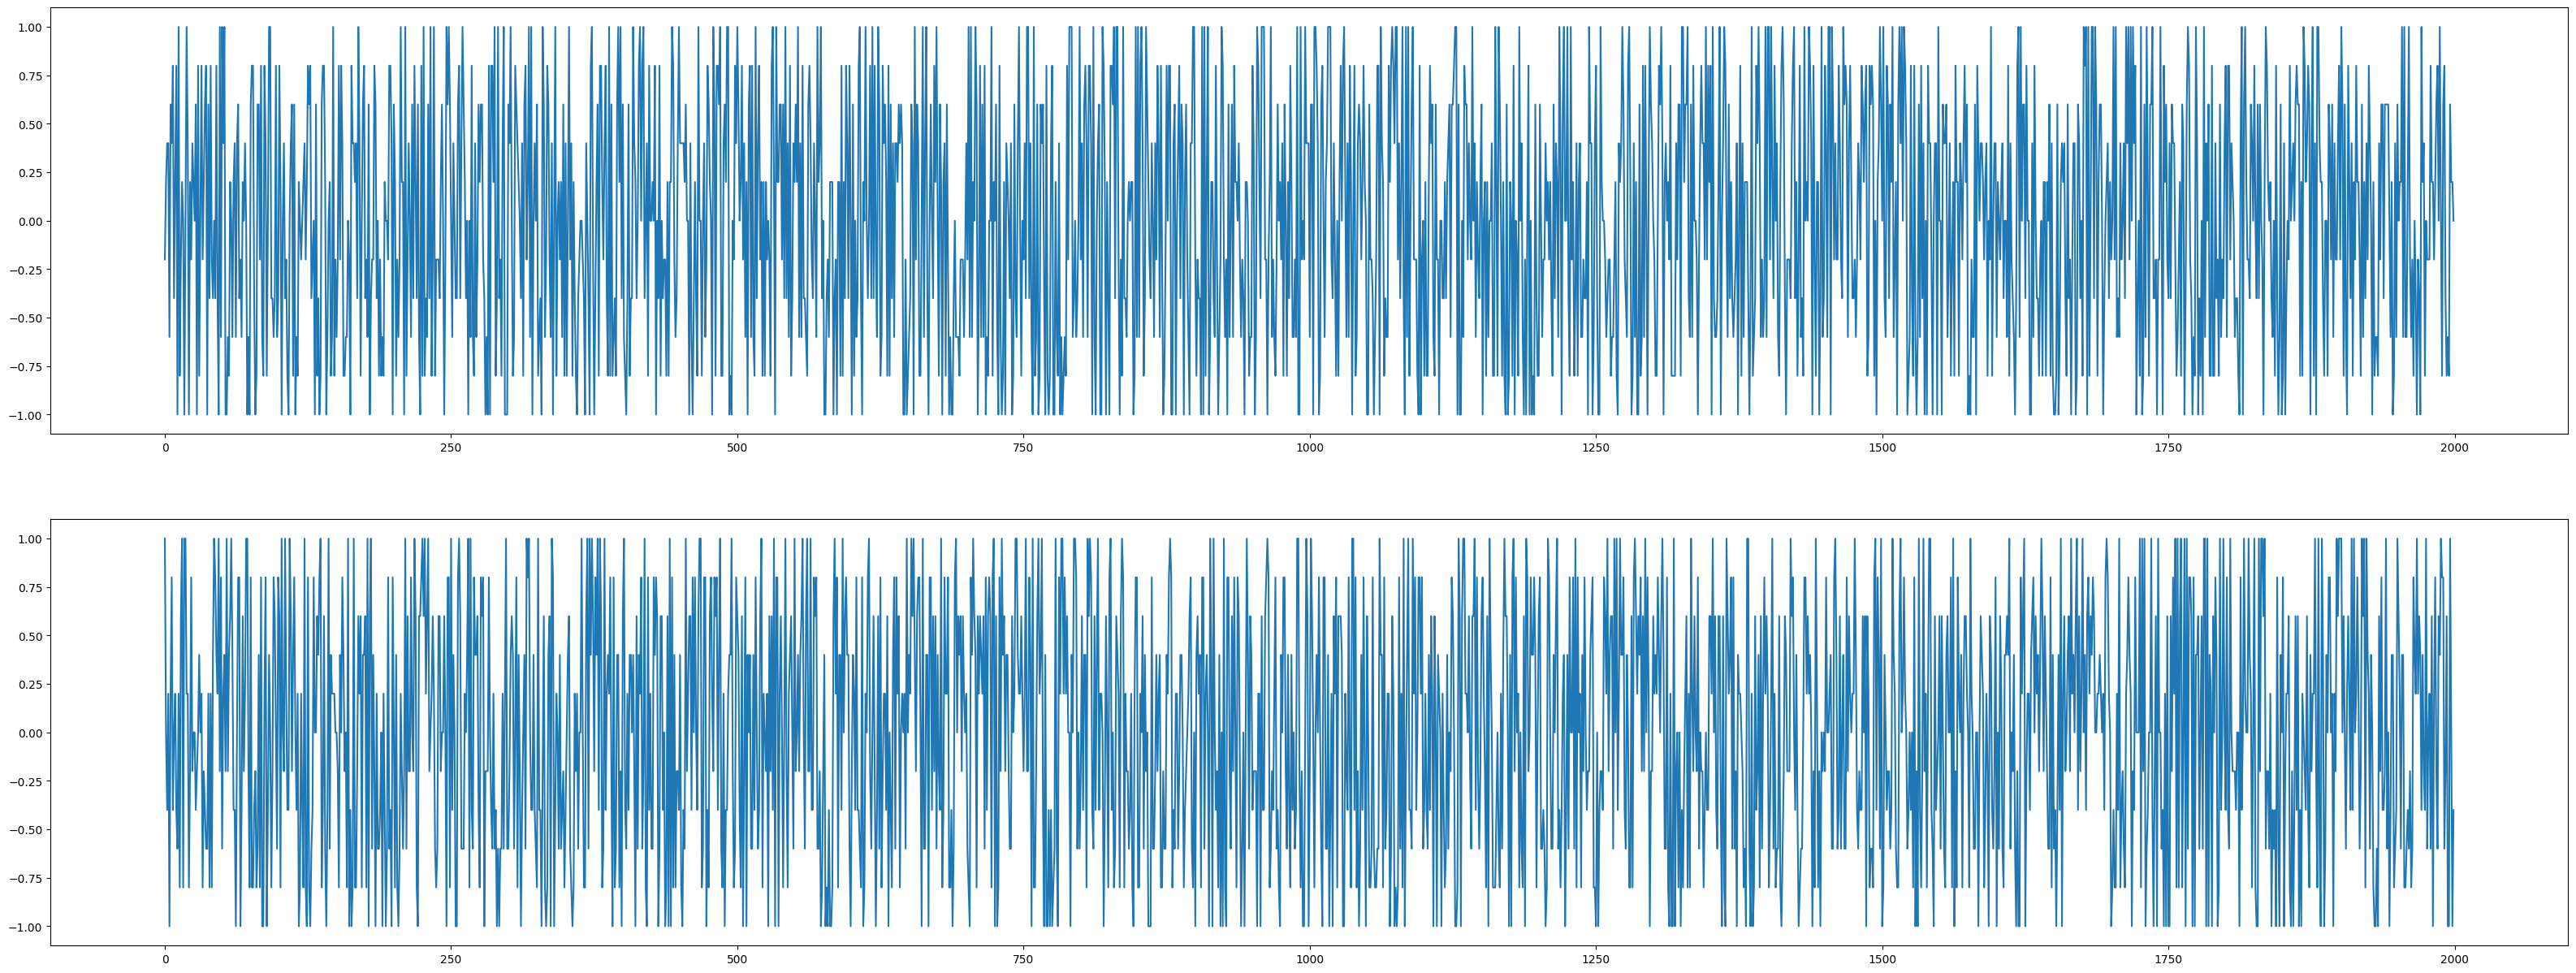

In [56]:
actionlist = np.array(actionlist)
plt.figure(figsize=(40,15))
plt.subplot(2,1,1)
plt.plot(actionlist[:,0][-2000:])
plt.subplot(2,1,2)
plt.plot(actionlist[:,1][-2000:])
plt.show()

In [66]:
env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()
for i in range(80000):
  env.step([np.random.random(),np.random.random()])
s,r,done,_ = env.step([1.0,1.0])
print(s[0][0])
print(r)

env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()
for i in range(80000):
  env.step([np.random.random(),np.random.random()])
s,r,done,_ = env.step([0.0,0.0])
print(s[0][0])
print(r)

env = HEV(fmu_filename, start_time, stop_time, step_size, soc_init, vehicle_speed_profile)
env.reset()
for i in range(80000):
  env.step([np.random.random(),np.random.random()])
s,r,done,_ = env.step([-1.0,-1.0])
print(s[0][0])
print(r)

0.004251733332630325
-0.41845391508653534
0.004232417249089
-0.42022286747400456
0.0042284953758145475
-0.42058248535727577


In [ ]:
starttime = 0
endtime = 10000
valuetable = np.zeros([timestep, len(action_grid))
for i in range(starttime,endtime):
  for j in range(len(action_grid)):
    if j==0 or j == len(action_grid)-1:
      